In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import ToTensor, Compose, RandomAffine

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def to_gpu(data):
    if isinstance(data, (list, tuple)):
        return [to_gpu(x) for x in data]
    return data.cuda()

In [3]:
class GPULoader:
    
    def __init__(self, dl):
        self.dl = dl
        
    def __iter__(self):
        for b in self.dl:
            yield to_gpu(b)
    
    def __len__(self):
        return len(self.dl)

In [4]:
train_trans = Compose([RandomAffine(30, translate=(0.15, 0.15)), ToTensor()])
test_trans = Compose([ToTensor()])
train_dataset = torchvision.datasets.MNIST('./mnist', train=True, transform=train_trans, download=True)
test_dataset = torchvision.datasets.MNIST('./mnist', train=False, transform=test_trans)

noisy_data = torchvision.datasets.MNIST('./mnist', train=False, transform=Compose([RandomAffine(30), ToTensor()]), download=True)

In [5]:
class NoisyLoader:
    
    def __init__(self, dl, size=28, just_noise_ratio=0):
        self.dl = dl
        self.size = size
        self.just_noise_ratio = just_noise_ratio
        
    def __iter__(self):
        for images, labels in self.dl:
            labels = torch.eye(10)[labels] # converting to one-hot encoding
            
            # first, we create just a noise
            noise = torch.rand((len(labels), 1, self.size, self.size))
            
            # i wish, i knew a way to do it without that for loop
            for i, image in enumerate(images):
                
                # some of images will contain only a noise
                # and the labels for them will be [0.1, ..., 0.1]
                # the ratio of such images is set via just_noise_ratio
                # choosing a fixed number of such images might
                # make training metrics more meaningful
                if np.random.random() < self.just_noise_ratio:
                    labels[i] = torch.full_like(labels[i], 1 / 10, dtype=torch.float)
                    continue
                    
                # inserting the number into a random place
                
                # the 2nd argument in torch.randint must be > then the 1st,
                # so we have to handle this case separately
                if self.size==28:
                    x = y = 0
                else:
                    x, y = torch.randint(0, self.size-28, (2,)).int()
                    
                noise[i, :, x:x+28, y:y+28] = torch.where(image!=0, image, noise[i, :, x:x+28, y:y+28])
                
            yield noise, labels
    
    def __len__(self):
        return len(self.dl)

In [6]:
batch_size = 100

train_loader = GPULoader(NoisyLoader(
                DataLoader(train_dataset, batch_size=batch_size, shuffle=True), 28, just_noise_ratio=0.09))
                
test_loader = GPULoader(NoisyLoader(DataLoader(test_dataset, batch_size=batch_size), 28))

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=2), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=2), nn.BatchNorm2d(64), nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=1), nn.BatchNorm2d(32), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(32, 10, kernel_size=1))
        self.softmax = nn.Softmax(1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.softmax(out)
        
        return out

In [8]:
model = to_gpu(CNN())

In [9]:
lr = 1e-3
n_epochs = 50

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

In [11]:
# the default crossentropy takes labels in ordinal format
# so we have to implement a custom one

def one_hot_crossentropy(preds, target):
    return -torch.sum(target*torch.log(preds))

In [12]:
n_steps = len(train_loader)
verbose_interval = 10000 // batch_size

history = {'train_loss_mean':[], 'train_acc_mean':[], 'test_loss_mean':[], 'test_acc':[]}


for epoch in range(n_epochs):
    print(f'epoch: {1 + epoch}/{n_epochs}')
    
    train_losses = []
    train_accs = []
    
    for i, (train_images, train_labels) in enumerate(train_loader):
        y_pred = model(train_images).squeeze() 

        loss = one_hot_crossentropy(y_pred, train_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # outputting progress
        if (i % verbose_interval == 0 or i + 1 == n_steps):
            with torch.no_grad():
                _, preds_class = torch.max(y_pred, 1)
                _, true_class = torch.max(train_labels, 1)
                
                train_accuracy = (true_class == preds_class).sum().item() / batch_size
                    
                print(f'step {1 + i}/{n_steps}: loss: {loss.item()}, train accuracy: {train_accuracy:.3f}')
                
                train_losses.append(loss.item())
                train_accs.append(train_accuracy)
    
    # calculating metrics on a test set
    # and printing it along with the means of train metrics
    # in not a very fancy way
    
    test_correct = 0
    
    test_losses = []
                
    for test_images, test_labels in test_loader:
        preds = model(test_images).squeeze()
        
        test_losses.append(one_hot_crossentropy(preds, test_labels).item())
        
        _, preds_class = torch.max(preds, 1)
        _, true_class = torch.max(test_labels, 1)
        test_correct += (true_class == preds_class).sum().item()

    test_accuracy = test_correct / (len(test_loader) * batch_size)

    print(f'test accuracy: {test_accuracy}, test loss: {sum(test_losses) / len(test_losses)}')
    
    history['train_loss_mean'].append(sum(train_losses) / len(train_losses))
    history['train_acc_mean'].append(sum(train_accs) / len(train_accs))
    
    history['test_loss_mean'].append(sum(test_losses) / len(test_losses))
    history['test_acc'].append(test_accuracy)
    
    scheduler.step(sum(test_losses) / len(test_losses))
    

epoch: 1/50
step 1/600: loss: 231.08863830566406, train accuracy: 0.100
step 101/600: loss: 162.427978515625, train accuracy: 0.530
step 201/600: loss: 92.07166290283203, train accuracy: 0.760
step 301/600: loss: 75.5208511352539, train accuracy: 0.760
step 401/600: loss: 77.07115936279297, train accuracy: 0.710
step 501/600: loss: 65.18528747558594, train accuracy: 0.760
step 600/600: loss: 49.20149612426758, train accuracy: 0.830
test accuracy: 0.9519, test loss: 19.170542116165162
epoch: 2/50
step 1/600: loss: 47.429405212402344, train accuracy: 0.840
step 101/600: loss: 54.551998138427734, train accuracy: 0.810
step 201/600: loss: 48.34615707397461, train accuracy: 0.830
step 301/600: loss: 61.273075103759766, train accuracy: 0.780
step 401/600: loss: 35.8248176574707, train accuracy: 0.860
step 501/600: loss: 56.22002410888672, train accuracy: 0.790
step 600/600: loss: 46.19455337524414, train accuracy: 0.800
test accuracy: 0.9621, test loss: 12.762530760765076
epoch: 3/50
step 1/

In [20]:
# makes the model use saved stats in batch normalization layers
# might affect the performance?
model.train(False);

In [14]:
def Detect(model, image, k=4):
    image_width, image_height = image.squeeze().shape
    
    image_s = image.view(1, 1, image_width, image_height)
    
    conv = model(image_s).squeeze()
    
    conv_width = conv.shape[1] # conv.shape = 10xWxH
    conv_height = conv.shape[2]
    
    confidences = torch.max(conv, dim=0)[0]
    predictions = torch.argmax(conv, dim=0)
    
    # looking for pixels with top k confidences 
    # in a flattened confidences tensor and storing them
    # also storing the flat view of model predictions
    top_index_flat = torch.topk(confidences.view(-1), k)[1]
    top_conf_flat = confidences.view(-1)[top_index_flat]
    prediction_flat = predictions.view(-1)
    
    # it is not really a voting
    # it just calculates a class with 
    # the greatest sum of confidences 
    # along stored top k
    voting = [0] * 10
    
    for conf, index in zip(top_conf_flat, top_index_flat):
        voting[prediction_flat[index]] += conf
    
    pred = np.argmax(voting)
    
    # the center of the bounding box in
    # convoluted coordinates is calculated
    # as a mean of the coordinates of stored top k pixels
    highest_conf_x =  torch.mean((top_index_flat % conv_width).float())
    highest_conf_y = torch.mean((top_index_flat / conv_width).float())
    
    # translating the coordinates of the center of the square to 128x128 image size
    orig_conf_center_x = 14 + (highest_conf_x * (image_width-28) / (conv_width-1)).int()
    orig_conf_center_y = 14 + (highest_conf_y * (image_height-28) / (conv_height-1)).int()
    
    # the final square
    topLeft = orig_conf_center_x - 14, orig_conf_center_y - 14
    bottomRight = orig_conf_center_x + 14, orig_conf_center_y + 14

    return pred, (topLeft, bottomRight)

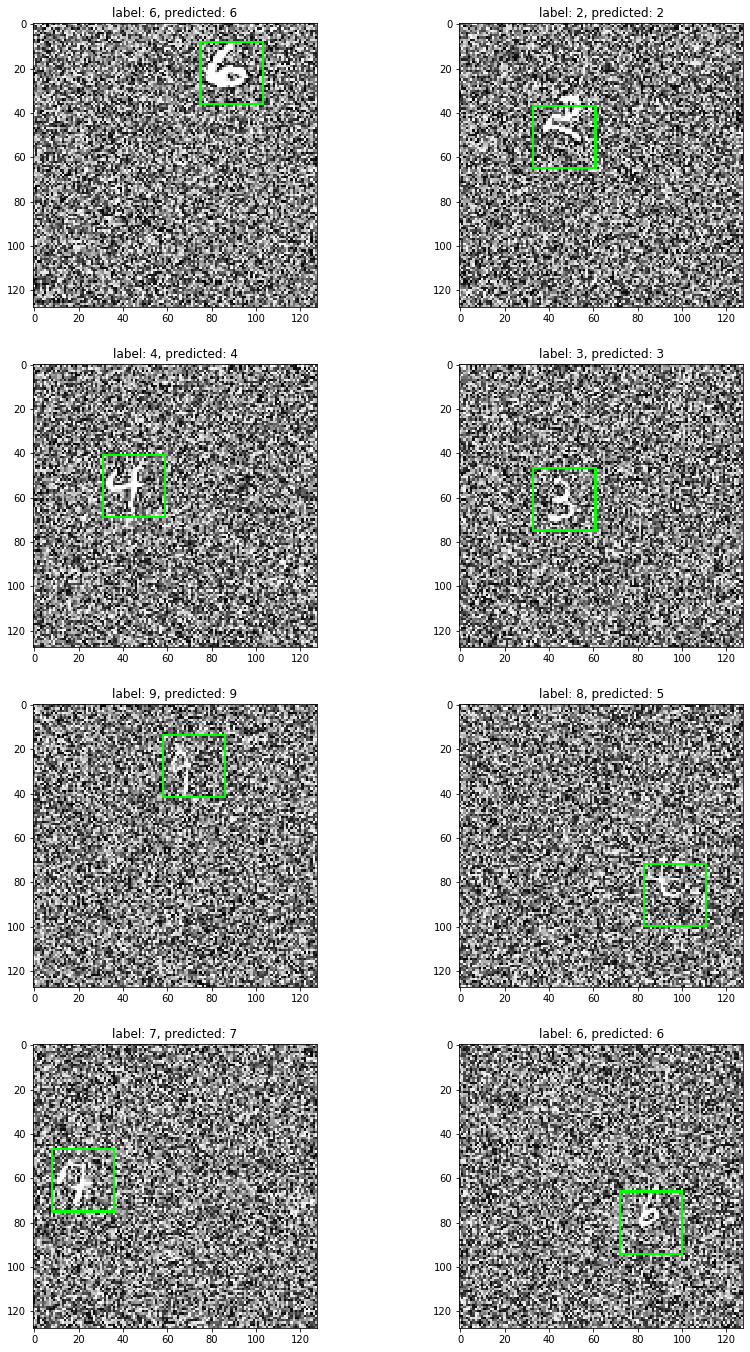

In [15]:
num_images = 8 # > 2

noisy_loader = GPULoader(NoisyLoader(DataLoader(noisy_data, batch_size=num_images, shuffle=True), 128))

for noisy_images, labels in noisy_loader:
    num_columns = 2
    num_rows = (num_images+num_columns-1)//num_columns
    
    fig, ax = plt.subplots(num_rows, num_columns, figsize=(14, 6*num_rows))
    
    for i, (image, label) in enumerate(zip(noisy_images, labels)):
        pred, (topLeft, bottomRight) = Detect(model, image.squeeze())
        
        # converting to rgb
        image_cv = cv2.cvtColor(image.squeeze().cpu().numpy(), cv2.COLOR_GRAY2RGB)
        # drawing a green bounding box
        image_cv = cv2.rectangle(image_cv, topLeft, bottomRight, (0, 1, 0))
        
        ax[i//num_columns, i%num_columns].set_title(f'label: {label.argmax()}, predicted: {pred}')
        ax[i//num_columns, i%num_columns].imshow(image_cv)
        
    break # we only need one batch

In [16]:
# it is doing pretty well
# let's try different k's

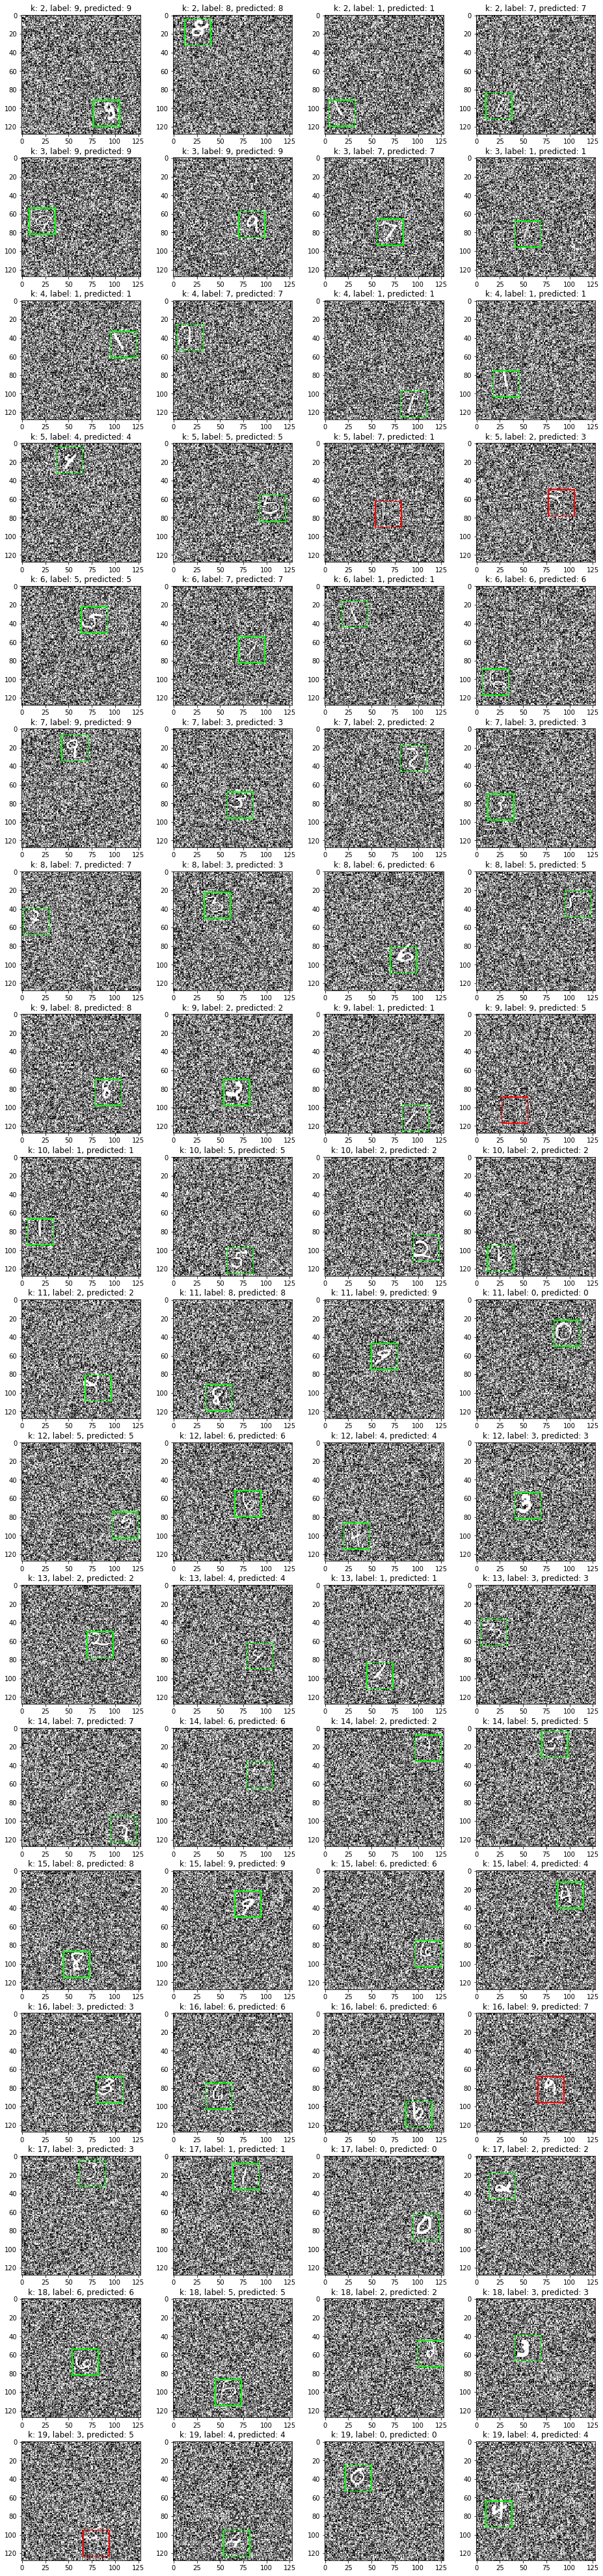

In [17]:
# it is a good idea to run this cell multiple times
one_k_images = 4

noisy_loader = GPULoader(NoisyLoader(DataLoader(noisy_data, batch_size=one_k_images, shuffle=True), 128))

k_list = range(2, 20)

num_columns = one_k_images
num_rows = len(k_list)

fig, ax = plt.subplots(num_rows, num_columns, figsize=(16, (16//num_columns)*num_rows))

for k_index, k in enumerate(k_list):

    for noisy_images, labels in noisy_loader:
        for image_index, (image, label) in enumerate(zip(noisy_images, labels)):
            pred, (topLeft, bottomRight) = Detect(model, image.squeeze())

            # converting to rgb
            image_cv = cv2.cvtColor(image.squeeze().cpu().numpy(), cv2.COLOR_GRAY2RGB)
            
            # drawing a bounding box
            # green for correct predictions
            # red for incorrect
            if pred == label.argmax():
                square_color = (0, 1, 0)
            else:
                square_color = (1, 0, 0)
            image_cv = cv2.rectangle(image_cv, topLeft, bottomRight, square_color)

            ax[k_index, image_index].set_title(f'k: {k}, label: {label.argmax()}, predicted: {pred}')
            ax[k_index, image_index].imshow(image_cv)

        break # we only need one batch

In [19]:
# possible improvements:
# model accuracy can be improved
# using a smarter bounding technique
# a faster noise generation technique (for example, the one that does not use python's for loop)